# title: Graph Convolutional Networks: Model Relations In Data

##### revised based on the reference: https://www.learnopencv.com/graph-convolutional-networks-model-relations-in-data/, and
#####  https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-62acf5b143d0
##### ☆☆☆ https://github.com/spmallick/learnopencv

## 1. the problem of Multi Label Image Classification (MLIC) for Image Tagging.
1. Categories.
  + Binary Classification
  + Multi-class classification
  + Multi-output classification
  + <span style="color:#B40431;background-color:#FBEFF2"> Multi-label classification </span>
  
### 1.1 Labels are Correlated
#### BW: <span style="color:#B40431;background-color:#FBEFF2"> Labels/Parts/Components are Correlated </span>
   Notice some of the tags are not independent. For example, if there is a sky label for an image, the probability of seeing the cloud or sunset labels for the same picture are high. The same holds true for the labels ocean, lake, and water labels.

   So it’s logical to assume that labels aren’t independent since in real life such objects or aspects are interconnected.

   This intuition is a core idea behind the most recent papers for MLIC. Researchers are trying to use prior knowledge about connections between labels to get better results.

   In the paper “[Multi-Label Image Recognition with Graph Convolutional Networks, 2019](https://arxiv.org/pdf/1904.03582.pdf)” the authors use **Graph Convolutional Network** (GCN) to encode and process relations between labels, and as a result, they get a 1–5% accuracy boost.
    
   The paper “[Cross-Modality Attention with Semantic Graph Embedding for Multi-Label Classification, 2020](https://arxiv.org/pdf/1912.07872.pdf)” proposes the further development of this idea. The authors added special attention to the approach from the former paper and obtained an additional 1–5% accuracy boost.

### 1.2 (Directional) Graph 
### BW: If it is directional graph, then row stands for the start node and column stands for the end node.
1. Before we move to the explanation of what GCNs are and how they’re applied to the task at hand, we should understand what are graphs and how are they related to our problem.

2. In CS, a **graph** is a structure that encodes relationships between objects.

3. In a graph, objects are represented using “nodes” while an “edge” between the nodes represents the relationship between the pair of the nodes.
    
    The edges may have their own weights to represent the strength of relationship between nodes. In such cases, the graph is **a weighted graph**.

4. Now, let’s look at some synthetical example that illustrates our image tagging task. Imagine we have a dataset with some vacation photos and 4 possible labels: ‘Sea’, ‘Sky’, ‘Sunset’, ‘Cloud’.

    We also have 8 data samples with the following labels assigned to them:
        1: ‘Sea’, ‘Sky’, ‘Sunset
        2: ‘Sky’, ‘Sunset’
        3: ‘Sky’, ‘Cloud’
        4: ‘Sea’, ‘Sunset’
        5: ‘Sunset’, ‘Sea’
        6: ‘Sea’, ‘Sky’
        7: ‘Sky’, ‘Sunset’
        8: ‘Sunset’

    We can represent the labels as the graph nodes, but what are the connections between them? We propose to add connections between each pair of labels with weights reflecting the probability of some label’s appearance given that another label is already here.
    
    Let’s elaborate a bit on that. The probability of each label in our dataset would be just the ratio of samples with this label divided by the total number of data samples. We’ve already noticed that some labels often come in pairs. This particular feature can be represented using the conditional probability, that’s $P(L_j|L_i)$, which denotes the probability of occurrence of label $L_j$ when label $L_i$ appears.

### 1.3 Adjacency matrix
1. Now let’s take a moment to talk about how we can represent the graph structure to make use of it in our DL pipeline.
    There are dozens of ways to represent graphs, but here we want to focus on a popular method that also fits our requirements – **adjacency matrix**.

2. For model training, we can compute this matrix based on the training dataset. First, we count the occurrences of label pairs in the training set and get the matrix $A\in R^{CxC}$ . Here, $C$ is the number of labels, $L_i$ is a specific label, and $A_{ij}$ denotes the number of samples with both labels $L_i$ and $L_j$.
    ![adjacency_matrix_01](./img/adjacency_matrix_01.png)
   
   We can calculate the number of occurrences for each label Li in the training dataset:
      ![adjacency_matrix_02](./img/adjacency_matrix_02.png)
      
   Then, by dividing this label co-occurrence matrix row by row (that’s $P_i = \frac{A_i}{N_i}$), we can get the conditional probabilities for each pair of labels.
      ![adjacency_matrix_03](./img/adjacency_matrix_03.png)
   Lastly, we add self-loops, because the probability of some label being on an image if it’s already here is 1:
      ![adjacency_matrix_04](./img/adjacency_matrix_04.png)
    vip: $P = P + Identity(length(P))$
   
   And now we have our weighted adjacency matrix which represents a directed weighted graph with 4 nodes and edges weighted according to the probability of each label pair co-occurrence.
    ![adjacency_matrix_05](./img/adjacency_matrix_05.png)
   Note that probabilities $P(L_i|L_j)$ and $P(L_j|L_i)$ are not equal and that’s normal. For instance if there is a Cloud, the probability of having Sky is 1.0. But if there is a sky, the probability of Cloud is 0.2 – the sky may have no clouds.

### 1.4 Graph Convolution vs Convolution
We all know about a standard Convolution layer. It works as a filter and extracts features from numerical data (such as images, signals, etc.). The graph convolution layer has the same logic. It works as a filter and extracts the features from graphs. To draw more parallels between them, it’s better to think about *the image as a graph with adjacent pixels connected by edges*.
   ![adjacency_matrix_06](./img/adjacency_matrix_06.png)

### 1.5 Graph Convolution in general
1. In the Convolution layer, we use the size of the convolution kernel to indicate the size of the neighborhood (how many pixels will contribute to the resulting value). Similarly, the Graph Convolution layer uses neighbors of a particular graph node to define a convolutional operation in it. Two nodes are neighbors if they have a common edge. In Graph Convolutions a learnable weight is multiplied by features of all the neighbors of a particular node (including the node itself) and some activation function is applied on top of the result. Formally, the result of Graph Convolution applied at node $v_{i}$ with a corresponding feature vector $h_{v_{i}}$ would be:
  \begin{equation}
    \hat{h}_{v_{i}}=f\left(\sum_{j \in N} \frac{1}{c_{i j}} h_{v_{j}} W\right)
   \end{equation}
  Here $N$ is an index set of neighborhood nodes of the node $v_i$ (it also includes i), $W$ is a learnable weight that is the same for all nodes in the neighborhood, and $f$ is some non-linear activation function.

2. Let’s now explain what <span style="color:#B40431;background-color:#FBEFF2"> $c_{ij}$ </span> is and how to implement this operation. It’s a constant parameter for the edge $(v_i, v_j)$ from the symmetrical normalization matrix. We compute this matrix by multiplying inversed degree matrix $D$ and binary adjacency matrix $A$ (we will describe how to get **binary adjacency matrix** from the weighted one further), so <span style="color:#B40431;background-color:#FBEFF2"> symmetric normalization matrix </span> is computed once for the input graph as follows:
  \begin{equation}
    D^{-1/2} A D^{-1/2}
  \end{equation}

### 1.5+ Graph Convolution in general (an alternative)
###### ref: https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780

3. An alternative discription of the content above: A hidden layer in the GCN can thus be written as $H_i=f(H_{i-1}, A)$ where $H_0=x$ and $f$ is a propagation. Each layer $H_i$ corresponds to an $N\times F_i$ feature matrix where each row is a feature representation of a node.
   
   One of the simplest possible propagation rule is:
    \begin{equation}
    f(H_i, A) = \sigma(A H_i W_i)
    \end{equation}
   where $W_i$ is the weight matrix for layer $i$ and $\sigma$ is a non-linear activation function such as the ReLU function. The weight matrix has dimensions $F_i \times F_{i+1}$; in other words the size of the second dimension of the weight matrix determines the number of features at the next layer. If you are familiar with convolutional neural networks, this operation is similar to a filtering operation since these weights are shared across nodes in the graph.
   
   ☆When we apply the propagation rule, what happened? The representation of each node (each row) is now a sum of its **neighbors** features (**not all the nodes,just neighbors**)! In other words, the graph convolutional layer represents each node as an aggregate of its **neighborhood (should includes itself)**. Note that in this case a node n is a **neighbor** of node v if there exists an edge from v to n.
   
   1/2. Should add the node itself to the neighborhood.
   2/2. Should perform normalization on the adjacency matrix before use by:
    ```python
        D = np.array(np.sum(A, axis=0))[0] 
        D = np.matrix(np.diag(D)
        A = D**-1 * A
    ```
    Observe that the weights (the values) in each row of the adjacency matrix have been divided by the degree of the node corresponding to the row. Note that here D_hat is the degree matrix of A_hat = A + I, $X_{NextLayer} = ReLU(\hat{D}**-1 * \hat{A} * X * W)$. And if we want to reduce the dimensionality of the output feature representations we can reduce the size of the weight matrix W.
    
    The Zachary’s Karate Club data (small and efficient). It is a commonly used social network where nodes represent members of a karate club and the edges their mutual relations. While Zachary was studying the karate club, a conflict arose between the administrator and the instructor which resulted in the club splitting in two. The figure below shows the graph representation of the network and nodes are labeled according to which part of the club. The administrator and instructor are marked with ‘A’ and ‘I’, respectively.
    ![zachary_karate_club_01](./img/zachary_karate_club_01.png)

Zachary's Karate Club
A=[[0. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]
D_hat=[[17.  0.  0. ...  0.  0.  0.]
 [ 0. 10.  0. ...  0.  0.  0.]
 [ 0.  0. 11. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  7.  0.  0.]
 [ 0.  0.  0. ...  0. 13.  0.]
 [ 0.  0.  0. ...  0.  0. 18.]]
{0: array([0.24368022, 0.19348343]), 1: array([0.21933729, 0.1847019 ]), 2: array([0.21541014, 0.22453917]), 3: array([0.2265379 , 0.15881686]), 4: array([0.08529807, 0.10486235]), 5: array([0.29738095, 0.26548904]), 6: array([0.21591773, 0.19452078]), 7: array([0.10698082, 0.10698642]), 8: array([0.        , 0.07070385]), 9: array([0.        , 0.27950499]), 10: array([0.36494712, 0.25178481]), 11: array([0.        , 0.00507978]), 12: array([0.36864978, 0.15505683]), 13: array([0.02931134, 0.09845684]), 14: array([0.        , 0.07002836]), 15: array([0.08517427, 0.16104759]), 16: array([0.36316698, 0.32541855]), 17

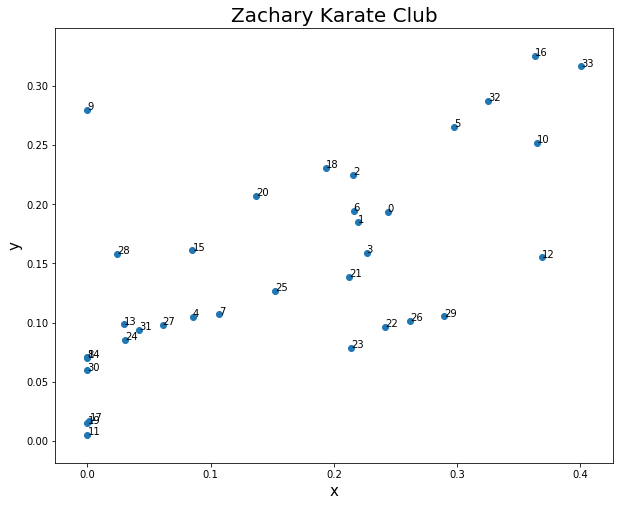

In [36]:
from networkx import karate_club_graph, to_numpy_matrix
import numpy as np
import matplotlib.pyplot as plt

if False:
    # Raw Data Plot
    import networkx as nx
    G = nx.karate_club_graph()
    print("Node Degree")
    for v in G:
        print('%s %s' % (v, G.degree(v)))
    nx.draw_circular(G, with_labels=True)
    plt.show()


# ---- Main GCN below -------#
zkc = karate_club_graph()
print(zkc.name)

order = sorted(list(zkc.nodes()))
A = to_numpy_matrix(zkc, nodelist=order)
I = np.eye(zkc.number_of_nodes())
A_hat = A + I  #with node itself in the neighborhood

D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))

print(f'A={A}')
print(f'D_hat={D_hat}')

# Weight initialize
W_1 = np.random.normal(
    loc=0, scale=1, size=(zkc.number_of_nodes(), 4))  #(xx,4)
W_2 = np.random.normal(
    loc=0, size=(W_1.shape[1], 2))   #(xx,2)

'''
Stack the GCN layers. We here use just the identity matrix as feature representation, 
that is, each node is represented as a one-hot encoded categorical variable.
'''
def gcn_layer(A_hat, D_hat, X, W):
    tmp = D_hat**-1 * A_hat * X * W
    return (abs(tmp) + tmp) / 2 #BW: aka ReLU

H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
output = H_2

# Extract the feature representations
feature_representations = {
    node: np.array(output)[node] 
    for node in zkc.nodes()}
print(feature_representations)

# Plot the leared feature representations
def plot_dict_values(dict_to_plot):
    fig, ax = plt.subplots()
    x, y = zip(*dict_to_plot.values())  # ☆☆☆ Revised from: key_lists, value_lists = zip(*lists)
    ax.scatter(x, y)

    ax.set_xlabel('x', fontsize=20)
    ax.set_ylabel('y', fontsize=20)
    ax.set_title('Zachary Karate Club')
    ax.grid(True)
    fig.tight_layout()
    plt.show()

# Plot the leared feature representations
xs, ys = zip(*feature_representations.values()) # ☆☆☆
labels = feature_representations.keys()    
# Show
plt.figure(figsize=(10,8))
plt.title('Zachary Karate Club', fontsize=20)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.scatter(xs, ys, marker = 'o')
for label, x, y in zip(labels, xs, ys):  # ☆☆☆
    plt.annotate(label, xy = (x, y))     # ☆☆☆

###### 👆BW: I should note that for this example the randomly initialized weights were very likely to give 0 values on either the x- or the y-axis as result of the ReLU function, so it took a few random initializations to produce the figure above.

+ A recent paper by Kipf and Welling proposes fast approximate **spectral graph convolutions** using a spectral propagation rule (more general):
 \begin{equation}
    f(X, A)=\sigma\left(\mathbf{D}^{-0.5} \hat{\mathbf{A}} \mathbf{D}^{-0.5} \mathbf{X} \mathbf{W}\right)
 \end{equation}

### Short Conclusion
###### We saw how we can build these networks using numpy and how powerful they are: even randomly initialized GCNs can separate communities in Zachary’s Karate Club based on the adjacency matrix.

### 1.5++ Normalized Adjacency and Laplacian Matrices
##### ref: [ORIE 6334 Spectral Graph Theory, Lecture 7, 2016](./img/Spectral_Graph_Theory.pdf)

1. **Definition 1** The normalized adjacency matrix is
    \begin{equation}
    \mathscr{A} \equiv D^{-1 / 2} A D^{-1 / 2}
    \end{equation}
  where $A$ is the adjacency matrix of $G$ and $D = diag(d)$ for $d(i)$ the degree of node $i$. For a graph $G$ (with no isolated vertices), we can see that:
   \begin{equation}
    D^{-1 / 2}=\left(\begin{array}{cccc}
    \frac{1}{\sqrt{d(1)}} & 0 & \cdots & 0 \\
    0 & \frac{1}{\sqrt{d(2)}} & \cdots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \cdots & \frac{1}{\sqrt{d(n)}}
    \end{array}\right)
   \end{equation}

2. **Definition 2** The normalized Laplacian matrix is:
    \begin{equation}
    \begin{array}{c}
    \mathscr{L} \equiv I-\mathscr{A} \\
    \mathscr{L}=I-\mathscr{A}=D^{-1 / 2}(D-A) D^{-1 / 2}=D^{-1 / 2} L_{G} D^{-1 / 2}
    \end{array}
    \end{equation}
  where $L_{G}$ the (unnormalized) Laplacian. “Normalizing” the adjacency matrix makes its largest eigenvalue equal 1.

### 1.5+++ Aggregation as a Weighted Sum (c\*A\*X)

We can understand the aggregation functions I’ve presented thus far as weighted sums where each aggregation rule differ only in their choice of weights. We’ll first see how we can express the relatively simple sum and mean rules as weighted sums before moving on to the spectral rule.

1. The Sum Rule as a Weighted Sum

To see how the aggregate feature representation of the ith node is computed using the sum rule, we see how the ith row in the aggregate is computed.
  \begin{equation}
    \begin{aligned}
    \operatorname{aggregate}(\mathbf{A}, \mathbf{X})_{i} &=\mathbf{A}_{i} \mathbf{X} \\
    &=\sum_{j=1}^{N} A_{i, j} \mathbf{X}_{j}
    \end{aligned}
 \end{equation}
 We can compute the aggregate feature representation of the ith node as a vector-matrix product. We can formulate this vector-matrix product as a simple weighted sum.

2. The Mean Rule as a Weighted Sum

To see how the mean rule aggregates node representations, we again see how the ith row in the aggregate is computed, now using the mean rule. For simplicity, we only consider the mean rule on the “raw“ adjacency matrix without addition between A and the identity matrix I which simply corresponds to adding self-loops to the graph.
 \begin{equation}
    \begin{aligned}
    \operatorname{aggregate}(\mathbf{A}, \mathbf{X})_{i} &=\mathbf{D}^{-1} \mathbf{A}_{i} \mathbf{X} \\
    &=\sum_{k=1}^{N} D_{i, k}^{-1} \sum_{j=1}^{N} A_{i, j} \mathbf{X}_{j} \\
    &=\sum_{j=1}^{N} D_{i, i}^{-1} A_{i, j} \mathbf{X}_{j} \\
    &=\sum_{j=1}^{N} \frac{1}{D_{i, i}} A_{i, j} \mathbf{X}_{j} \\
    &=\sum_{j=1}^{N} \frac{A_{i, j}}{D_{i, i}} \mathbf{X}_{j}
 \end{aligned}
 \end{equation}
 ☆ Whereas the sum rule depends solely on the neighborhood defined by the adjacency matrix A, the mean rule also depends on node degrees.
 
3. The Spectral Rule as a Weighted Sum

We now have a useful framework in place to analyse the spectral rule. Let’s see where it takes us!
    \begin{equation}
    \begin{aligned}
        \operatorname{aggregate}(\mathbf{A}, \mathbf{X})_{i} &=\mathbf{D}^{-0.5} \mathbf{A}_{i} \mathbf{D}^{-0.5} \mathbf{X} \\
        &=\sum_{k=1}^{N} D_{i, k}^{-0.5} \sum_{j=1}^{N} A_{i, j} \sum_{l=1}^{N} D_{j, l}^{-0.5} \mathbf{X}_{j} \\
        &=\sum_{j=1}^{N} D_{i, i}^{-0.5} A_{i, j} D_{j, j}^{-0.5} \mathbf{X}_{j} \\
        &=\sum_{j=1}^{N} \frac{1}{D_{i, i}^{0.5}} A_{i, j} \frac{1}{D_{j, j}^{0.5}} \mathbf{X}_{j}
    \end{aligned}
    \end{equation}
    
 ☆  When computing the aggregate feature representation of the ith node, we not only take into consideration the degree of the ith node, but also the degree of the jth node.
 
 ☆ Similar to the mean rule, the spectral rule normalizes the aggregate **s.t.(subject to)** the aggregated feature representation remains roughly on the same scale as the input features. However, the spectral rule weighs neighbor in the weighted sum higher if they have a low-degree and lower if they have a high-degree. This may be useful when low-degree neighbors provide more useful information than high-degree neighbors.

### 1.5-TBD: Semi-Supervised Classification with GCNs
###### ref: https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-62acf5b143d0

### 1.6 Graph Convolutional Networks
1. Naturally, we can stack multiple Graph Convolution layers alternating them with activation functions, just like we do in CNNs. Thus we get Graph Convolution Network (GCN).
   ![adjacency_matrix_07](./img/adjacency_matrix_07.png)

2. Let’s now outline the whole GCN pipeline we are going to use in our example. We have a graph with $C$ nodes, and we would like to apply the GCN. The goal of Graph Convolutional operation is to learn a function of input/output features. Given a **(directional)** graph $G=(Vertex, E)$, GCN takes as input:
  + it takes a $C\times D$ feature matrix ($D$ is the dimension of the input features), and
  + a weighted adjacency matrix $P$ that represents the graph structure in a matrix form.

  Then several Graph Convolutions are applied sequentially with ReLU as an activation function. The output of Graph Convolutional operation is a $C\times F$ feature matrix, where $F$ is the number of output features per node.

In [1]:
class GraphConvolution(nn.Module):
    """
        Simple GCN layer, similar to 
        https://arxiv.org/abs/1609.02907
    """
    def __init__(self, in_features_dim, out_features_dim, bias=False):
        super(GraphConvolution, self).__init__()
        self.in_features_dim = in_features_dim
        self.out_features_dim = out_features_dim
        self.weight = Parameter(
                  torch.Tensor(in_features_dim, out_features_dim), #☆ Weight determines the dim of out_features. 
                  requires_grad=True)
        if bias:
            self.bias = Parameter(
                         torch.Tensor(1, 1, out_features_dim), 
                         requires_grad=True)
        else:
            self.register_parameter('bias', None)
        self._reset_parameters()

    def _reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.matmul(input.float(),
                               self.weight.float())
        output = torch.matmul(adj, support) #Adjacency matrix
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features_dim) + ' -> ' \
               + str(self.out_features_dim) + ')'

NameError: name 'nn' is not defined

### 1.7 Label vectorization (GloVe)

We just discussed how GCNs work and how they take a feature matrix as input with a feature vector per node. **In our task though, we don’t have any features for labels, just their names. (BW: That's why we need to encode the texts.)** When working with text in neural networks, a vector representation of words is usually used. Each vector represents a specific word in the space of all words of the corpus (dictionary) on which this space was calculated. The space of words is necessary to find the relationships between the words: the closer the vectors are to each other in this space, the closer their meanings are. You may see that the words with close meanings (like sky, sun, clouds) are close in the feature space. There are various approaches to obtaining this space, in our example, we use the **GloVe model** built on Wikipedia with a feature vector of length 300.

### 1.8 ML-GCN
We are going to implement the approach from the *Multi-Label Image Recognition with Graph Convolutional Networks* paper. It consists of applying all the steps described earlier:

+ [x] Calculate a weighted adjacency matrix from the training set.
+ [x] Calculate the matrix with per-label features: X=LxD
+ [x] Use vectorized labels X and weighted adjacency matrix P as the input of the graph neural network, and preprocessed image as the input for the CNN network.
+ [x] Train the model!

We’d like to discuss several practical tricks left before moving to the implementation of this approach.

When training on real data, usually the following problems arise: overfitting and over-smoothing. The ways to solve them when working with the Multi-Label Graph Convolutional Networks (ML-GCN) are described below.👇

#### 1.8.1 Weighted adjacency matrix thresholding

To avoid overfitting, we filter the pairs in the weighted adjacency matrix that have probabilities lower than a certain threshold τ (we use τ=0.1). Such edges we interpret as being poorly represented or error connections. That may happen, for example, due to the noise in training data. For example, in our case such connections are ‘birds’ and ‘nighttime’: they represent random coincidences rather than real relations.
    \begin{equation}
        \boldsymbol{A}_{i j}=\left\{\begin{array}{ll}
        0, & \text { if } \boldsymbol{P}_{i j}<\tau \\
        1, & \text { if } \boldsymbol{P}_{i j} \geq \tau
    \end{array}\right.
    \end{equation}

#### 1.8.2 Over-smoothing problem

☆ After applying a Graph Convolution layer, the feature of the node will be the weighted sum of its own feature and the adjacent nodes’ features. The reweighted adjacency matrix is shown below:
    \begin{equation}
        \boldsymbol{A}_{i j}^{\prime}=\left\{\begin{array}{ll}
        p / \sum_{j=1 \atop i \neq j}^{C} \boldsymbol{A}_{i j}, & \text { if } i \neq j \\
        1-p, & \text { if } i=j
    \end{array}\right.
    \end{equation}

It may result in an over-smoothing of the features in a particular node, especially after applying several layers. To prevent this, we introduce a parameter p that calibrates the weights assigned to the node itself and other correlated nodes. By doing this, when updating the node feature, we will have a fixed weight for the node itself, and the weights for its neighbor nodes will be determined by the neighborhood distribution. When p → 1, the feature of the node itself will not be considered. On the other hand, when p → 0, neighboring information tends to be ignored. In our experiments, we use p=0.25.

### 1.9 GCN
Finally, let’s construct the model with GCN. We took the first 4 layers from $ResNeXt50$ as a visual feature extractor and used multi-layer GCN as a label relationship extractor. Features from the image itself and the labels are then combined via a dot product operation. See the scheme below:
    ![ML_GCN_arch](./img/ML_GCN_arch.png)

In [ ]:
# Create adjacency matrix from statistics.
def gen_A(num_classes, t, p, adj_data):
    adj = np.array(adj_data['adj']).astype(np.float32)
    nums = np.array(adj_data['nums']).astype(np.float32)
    nums = nums[:, np.newaxis]
    adj = adj / nums
    adj[adj < t] = 0    #☆ Weighted adjacency matrix thresholding
    adj[adj >= t] = 1
    adj = adj * p / (adj.sum(0, keepdims=True) + 1e-6)    #☆ Over-smoothing problem
    adj = adj + np.identity(num_classes, np.int)
    return adj

# Apply adjacency matrix re-normalization trick.
def gen_adj(A):
    D = torch.pow(A.sum(1).float(), -0.5)  #☆ sum(axis=1): each row stands for the start (directional) node
    D = torch.diag(D).type_as(A)
    adj = torch.matmul(torch.matmul(A, D).t(), D)
    return adj


class GCNResnext50(nn.Module):
    def __init__(self, n_classes, adj_path, in_channel=300, #☆ X0 feature dim 300: (texts) label vectorization
                 t=0.1, p=0.25):
        super().__init__()
        self.sigm = nn.Sigmoid()

        self.features = models.resnext50_32x4d(pretrained=True)
        self.features.fc = nn.Identity()
        self.num_classes = n_classes

        self.gc1 = GraphConvolution(in_channel, 1024)
        self.gc2 = GraphConvolution(1024, 2048)
        self.relu = nn.LeakyReLU(0.2)
        
        # Load statistics data for adjacency matrix
        with open(adj_path) as fp:
            adj_data = json.load(fp)
        # Compute adjacency matrix
        adj = gen_A(n_classes, t, p, adj_data)
        self.A = Parameter(torch.from_numpy(adj).float(), 
                           requires_grad=False)

    def forward(self, imgs, inp):
        # Get visual features from image
        feature = self.features(imgs)
        feature = feature.view(feature.size(0), -1)
        
        # Get graph features from graph
        inp = inp[0].squeeze()
        adj = gen_adj(self.A).detach() #☆ copy without gradients
        x = self.gc1(inp, adj)
        x = self.relu(x)
        x = self.gc2(x, adj)
        
        # We multiply the features from GCN and CNN in order to 
        # take into account the contribution to the prediction of 
        # classes from both the image and the graph.
        x = x.transpose(0, 1)
        x = torch.matmul(feature, x)
        return self.sigm(x)

### 1.10 Accuracy comparison with the earlier post

Comparing ML-GCN with the naive approach from <span style="color:#B40431;background-color:#FBEFF2"> [the earlier post](https://www.learnopencv.com/multi-label-image-classification-with-pytorch-image-tagging/) </span>, we find that ML-GCN approach is more accurate:
    ![GCN_result_01](./img/GCN_result_01.png)

### 1.11 Summary
In this post, we’ve shown how to represent the graph structure in CNN, and how Graph Convolutional Networks works. We also applied them to a real-life task: multi-label classification of images. GCN has significantly increased the baseline accuracy there proving that GCNs are a powerful tool that can be used to further improve the quality and performance of a broad range of deep learning tasks.